In [1]:
try:
    import eyelinkparser
except ImportError:
    import pip
    pip.main(['install', 'python-eyelinkparser'])
    pip.main(['install', 'fastnumbers'])
    pip.main(['install', 'prettytable'])

Initializing cache ...


## Define custom parser.
# Override parse_phase.
# End phase was not properly placed in the experiment.

In [2]:
from eyelinkparser import EyeLinkParser, sample
from eyelinkparser import sample, fixation, defaulttraceprocessor
import warnings


class CustomParser(EyeLinkParser):
    
    def parse_phase(self, l):

        # For performance only check for start- and end-phase messages if there
        # actually is a message
        if l[0] == 'MSG':
            if self.match(l, u'MSG', int, (u'start_phase', u'phase'), str):
                self.start_phase(l)
                return
            if self.match(l, u'MSG', int,"var", "time_create_feedback",float):
                if self.current_phase != l[3]:
                    warnings.warn(u'Trace %s was ended while current phase was %s' \
                        % (l[3], self.current_phase))
                    return
                self.end_phase(l)
                return
        if self.current_phase is None:
            return
        s = sample(l)
        if s is not None:
            self.parse_sample(s)
            return
        f = fixation(l)
        if f is not None:
            self.parse_fixation(f)


# Parsing the data

- First, the `edf` files should be converted to `asc` with the `edf2asc` converter, which you can download from the SR Research forum.
- Next, place the `asc` files in a folder called `data`, which is a subfolder of the folder where this notebook is located.
- Then, run this script!

The `get_data()` function below parses the data. Because you have structured the experiment as expected by `eyelinkparser`, this is very easy. Blinks are reconstructed in the pupil trace, and the data is downsampled by a factor of 10 to 100 Hz. This is done automatically by the `defaulttraceprocessor()`.

We also perform baseline correction of the pupil trace, and reduce the length (depth) of the pupil trace to a sensible value that matches the length of the `presentation` phase during the experiment. Finally, we keep only a few columns (all other columsn are discarded), so that the data structure isn't too big.

In [3]:
from eyelinkparser import parse, defaulttraceprocessor
from datamatrix import operations as ops, series as srs, functional as fnc
from datamatrix import DataMatrix
from matplotlib import pyplot as plt
from datamatrix import plot
from matplotlib import pyplot as plt
from datamatrix import operations as ops
from datamatrix import series as srs
from scipy import stats
from scipy.stats import binom
import numpy as np


@fnc.memoize(persistent=True) # Remove persistent to use in-memory caching.
def get_data():
    
    dm = parse(
        parser=CustomParser,
        traceprocessor=defaulttraceprocessor(blinkreconstruct=True,downsample=10),        
    )
    
    dm.pupil = dm.ptrace_target

    dm = ops.keep_only(dm,
         "pupil",
         "gender",
         "age",              
         "start_color",
         "subject_nr",
         "start_shape",
         "presented_shape",
         "selected_shape",
         "percentage_correct",
         "response",
         "num_trial",
         "Practice",
         "feedback_text",
         "rsvp_count",              
         "count_trial_sequence"

    )

    return dm

We now call `get_data()` and store the result as `dm`. To speed up performance, `get_data()` is cached. To clear the cache, call `get_data.clear()`.

In [4]:
#get_data.clear() # Uncomment this to clear the memoization cache.
dm = get_data()



## Cleaning data

320 Before removal practice
240 After removal practice


C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\datamatrix\series.py:377: RuntimeWarning: Mean of empty slice
  a = operation(series, axis=1)
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['liberation sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


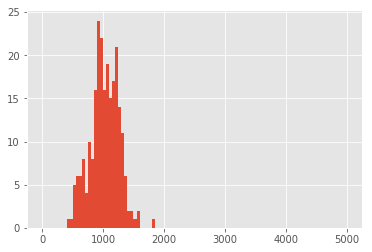

Before trimming: 240
After trimming: 225


C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\datamatrix\_datamatrix\_numericcolumn.py:158: RuntimeWarning: invalid value encountered in greater
  b = op(self._seq, _other)
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\datamatrix\_datamatrix\_numericcolumn.py:158: RuntimeWarning: invalid value encountered in less
  b = op(self._seq, _other)
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\datamatrix\series.py:1336: RuntimeWarning: invalid value encountered in less
  l = np.where(vtrace[ifrom:] < -vt)[0]
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\datamatrix\series.py:1344: RuntimeWarning: invalid value encountered in greater
  l = np.where(vtrace[istart:] > vt)[0]
C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\datamatrix\series.py:1351: RuntimeWarning: invalid value encountered in less
  l = np.where(vtrace[imid:] < 0)[0]
C:\Users\s1910833\AppData\Local\Continuum\anacon

In [5]:
# Remove practice trials.
print(len(dm),"Before removal practice")
dm = dm.Practice != "yes"
print(len(dm),"After removal practice")


# Baseline correction
from matplotlib import pyplot as plt
from datamatrix import series as srs

dm.pupil_baseline = srs.reduce_(srs.window(dm.pupil,0,10))

plt.hist(dm.pupil_baseline, bins = 100, range=(0,5000))
plt.show()

## 
# Trimming data
print("Before trimming: %d" %len(dm))
dm = (dm.pupil_baseline > 600) & (dm.pupil_baseline < 2000)
print("After trimming: %d" %len(dm))


# Blink reconstruct
dm.pupil = srs.blinkreconstruct(dm.pupil,vt=3,maxdur = 500, margin = 10,smooth_winlen = 21, std_thr=3 )


# Plotting pupil size across presented shape, start_shape and start_color
# The purpose of this analysis is to see whether the data contains artefacts.

C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['liberation sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


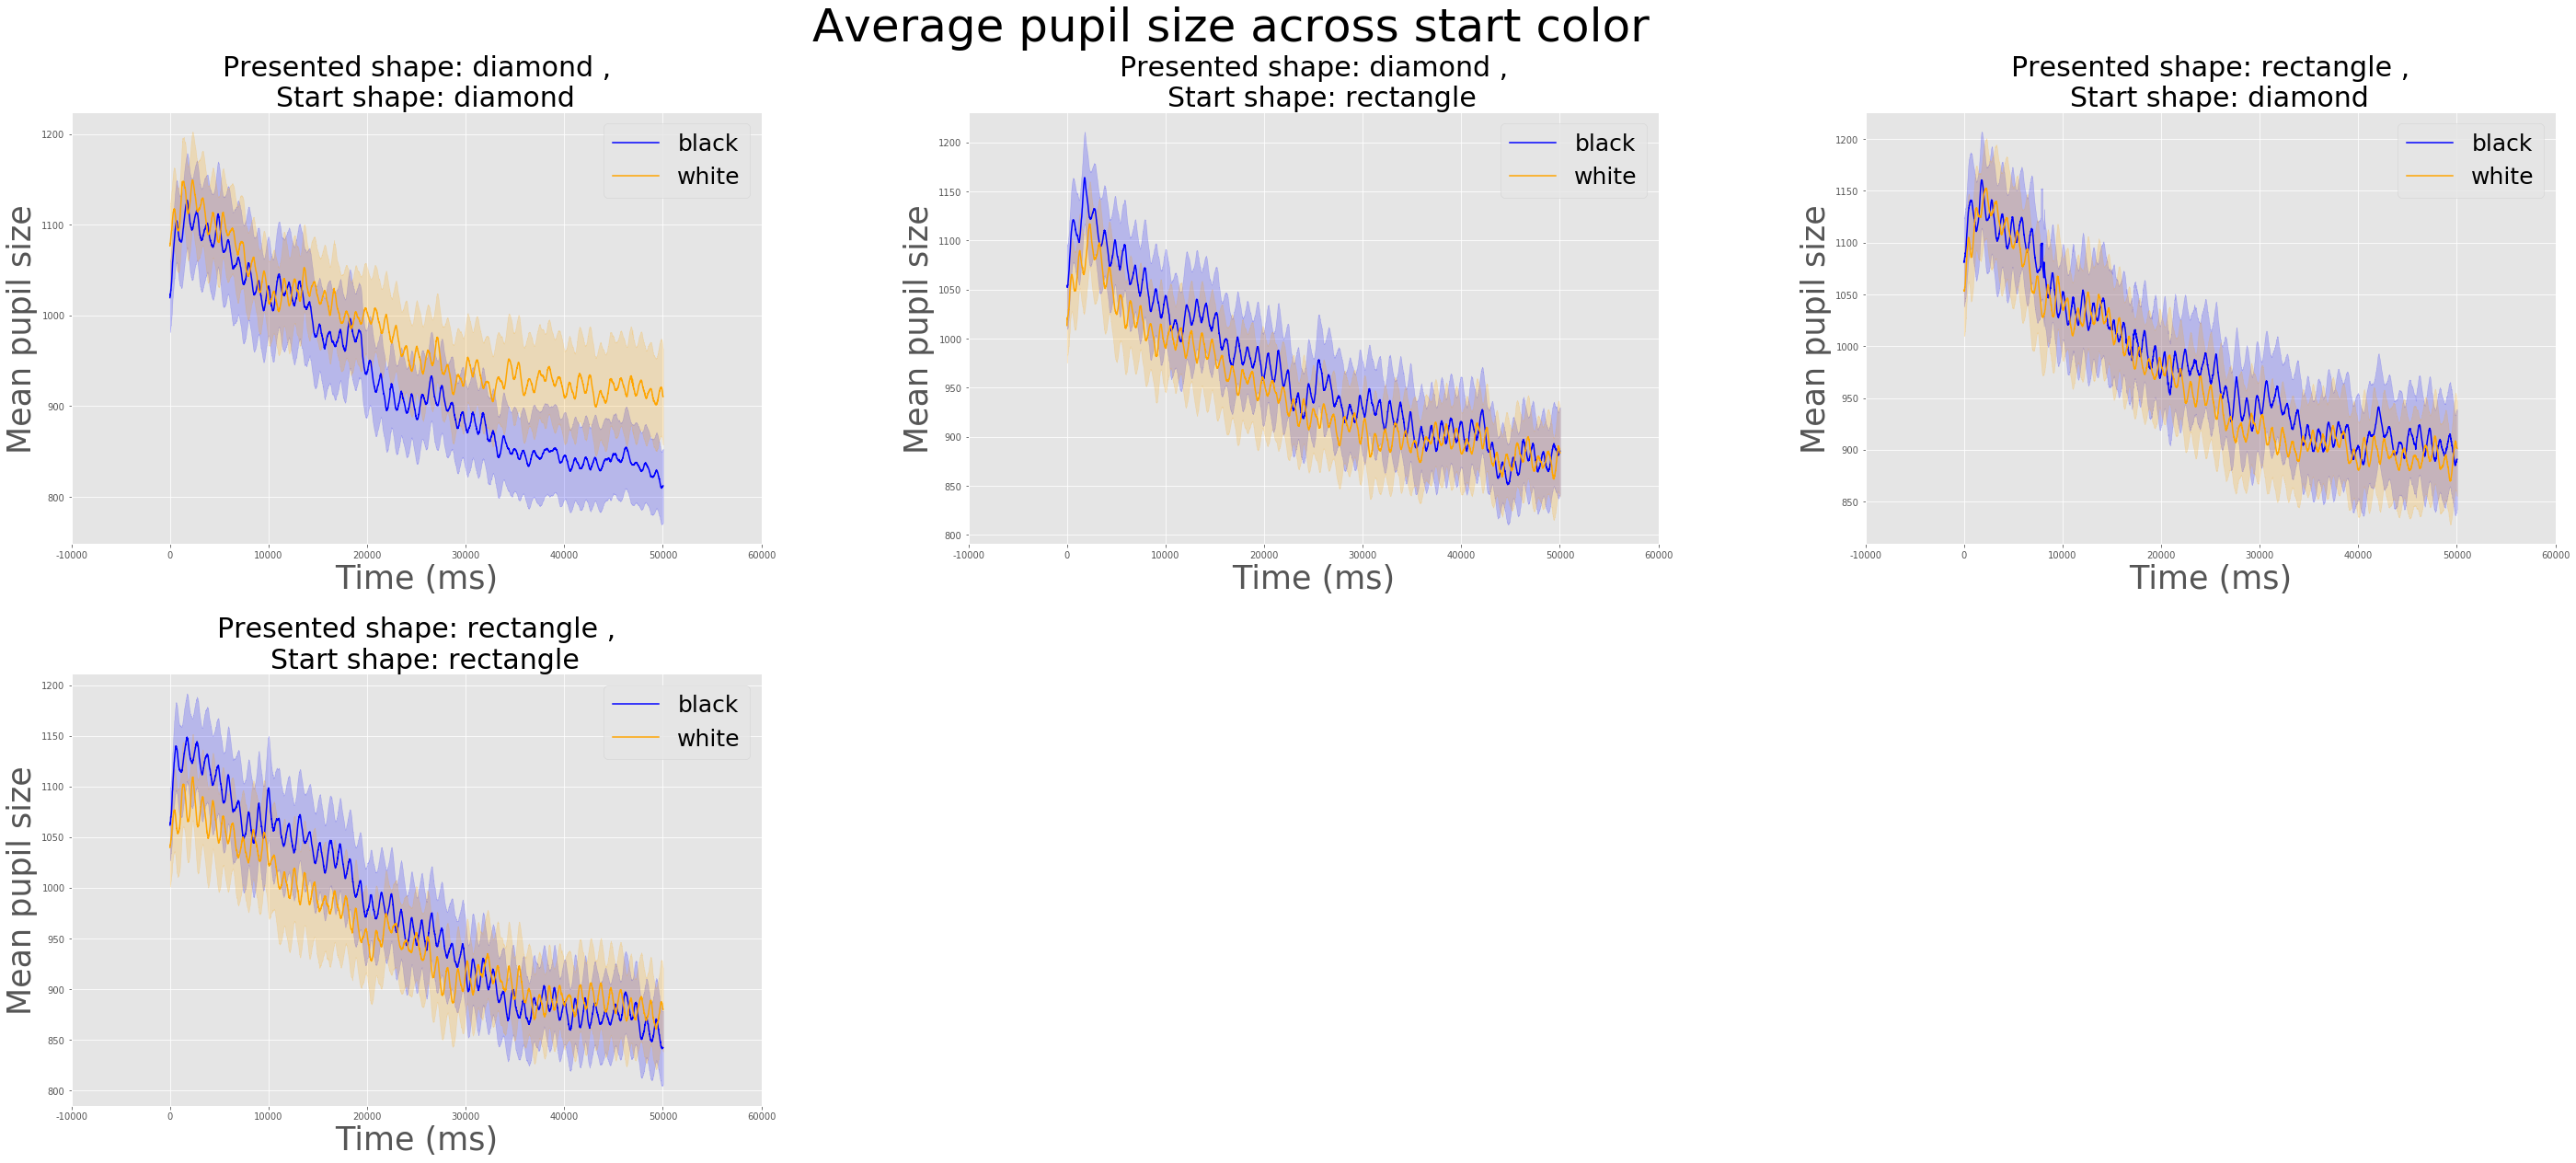

In [6]:

plot.new(size=(50,20))
plt.suptitle("Average pupil size across start color", fontsize = 50)
i = 0

for (presented_shape,dm_presented_shape) in (ops.split(dm.presented_shape)):
    for (start_shape,dm_start_shape) in (ops.split(dm_presented_shape.start_shape)):
        Axes = plt.subplot(2,3,i+1)
        i += 1
        plt.title("Presented shape: %s ,\n  Start shape: %s" % (presented_shape,start_shape), fontsize=30)
        colors = ["orange","blue"]

        for luminance, dm_luminance in ops.split(dm_start_shape.start_color):
            plot.trace(
                dm_luminance.pupil,
                label=luminance,
                color=colors.pop()  
            )
        plt.legend(fontsize = 25)
        plt.ylabel("Mean pupil size",fontsize=35)
        plt.xlabel("Time (ms)",fontsize=35)
        locs, labels = plt.xticks()
        x_label = [int(x*10) for x in locs]
        plt.xticks(locs,x_label)
        
    locs, labels = plt.xticks()

plt.show()

        


# General assessment experiment
# Age 
# Female, Male
# Avg % correct
# Probability results are chance level
# Potential bias towards shape


In [7]:

# Couting amount of correct.
dm_correct = dm.feedback_text == "correct"
print("Amount of correct trials", len(dm_correct))

# Sd
Female = 0
Male = 0

age = np.array([])
list_per_correct_pp = []
for (subj,dm_subj) in (ops.split(dm.subject_nr)):
    if dm_subj[0].age < 100:
        age = np.append(age,dm_subj.age[0])
    if dm_subj.gender == "Male":
        Male += 1
    elif dm_subj.gender == "Female":    
        Female += 1
    list_per_correct_pp = np.append(list_per_correct_pp,dm_subj.percentage_correct[len(dm_subj)-1])

print(age)
print("Age SD", np.std(age), "Age mean", np.mean(age))
print(np.std(list_per_correct_pp))
print("Len male", Male, "Length female",Female )

# Check ratio rsvp count. 
for (rsvp_count,dm_rsvp_count) in (ops.split(dm.rsvp_count)):
    print("Rsvp count",rsvp_count ,"Ratio", len(dm_rsvp_count)/len(dm)*100)


# Average % correct per participant.
for (subj,dm_subj) in (ops.split(dm.subject_nr)):
    print("Subject", subj, "Percentage correct",dm_subj.percentage_correct[len(dm_subj)-1])
    
# Average % correct across participants
print("Average percentage correct",(len(dm_correct)/len(dm))*100)

# Probability that the results are due to the chance (given that the null hypothesis is true)
print("P-value",stats.binom_test(len(dm_correct), n=len(dm),p=0.5))

# Checking potential bias towards a shape. 
dm_correct_rectangle = dm_correct.presented_shape == "rectangle"
print("Amount of correct trials for presented shape rectangle", len(dm_correct_rectangle))
dm_correct_diamond = dm_correct.presented_shape == "diamond"
print("Amount of correct trials for presented shape diamond", len(dm_correct_diamond))

#
dm_selected_rectangle = dm.selected_shape == "rectangle"
dm_selected_diamond =  dm.selected_shape == "diamond"
print("Length select diamond", len(dm_selected_diamond),"Length select rectangle", len(dm_selected_rectangle))






Amount of correct trials 133
[23. 24. 22. 22. 23. 24. 24. 22. 24.]
Age SD 0.8748897637790901 Age mean 23.11111111111111
7.783975705119924
Len male 7 Length female 3
Rsvp count 1 Ratio 9.333333333333334
Rsvp count 2 Ratio 13.777777777777779
Rsvp count 3 Ratio 76.88888888888889
Subject 1 Percentage correct 66.6666666667
Subject 2 Percentage correct 58.3333333333
Subject 3 Percentage correct 45.8333333333
Subject 4 Percentage correct 70.8333333333
Subject 5 Percentage correct 50
Subject 6 Percentage correct 62.5
Subject 7 Percentage correct 58.3333333333
Subject 8 Percentage correct 66.6666666667
Subject 9 Percentage correct 50
Subject 10 Percentage correct 58.3333333333
Average percentage correct 59.111111111111114
P-value 0.007522795992134583
Amount of correct trials for presented shape rectangle 65
Amount of correct trials for presented shape diamond 68
Length select diamond 115 Length select rectangle 109


# Plotting performance across trials (learning effect).
# Starting from trial_number five each point in the graph represents the average # Accuracy of all participants at that trial point and four trials before.

C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['liberation sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


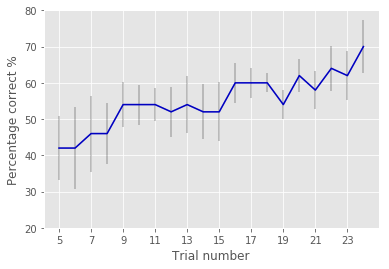

In [8]:
# Analyze percentage correct in bins of four (4,8,12,16,20,24)
# Take average percentage correct and standard error.

def supplement(array):
    if len(array) < 10:
        count_too_short = abs(len(array)-10)
        for a in range(count_too_short):
            array = np.append(array,float("nan"))
        return array
    elif len(array) >= 10:
        return array
    else:
        raise ValueError("Array size is not smaller or larger than 10")


def convert_feedback(x):
    if x == "correct":
        return 1
    elif x == "not correct":
        return 0
    else:
        raise ValueError("Not correct or correct")

# Initialising new lists acc/se.
list_acc = np.array([])
list_se_correct = np.array([])

# Creating an array for correct/incorrect per subject.
list_acc_pp = np.zeros([24,10])

# Creating an array for the running avg per trial.
list_run_avg = np.array([])

for (num_trial,dm_num_trial) in (ops.split(dm.num_trial)):
    acc_pp = [convert_feedback(x) for x in dm_num_trial.feedback_text]
    acc = np.sum([convert_feedback(x) for x in dm_num_trial.feedback_text])/10
    list_acc = np.append(list_acc,acc)   
    
    ## Supplementing array with nan values if len(array) < 10.
    acc_pp = supplement(acc_pp)
    
    # Accuracy per participants (columns are participants rows is trial number).
    list_acc_pp[num_trial-1] = acc_pp
    
    if num_trial > 4:
        
        # Array for averages accuracy per participant five trials before. 
        list_avg_pp = np.array([])

        ## Calculating averages per participant five trials before.
        # Going through all columns/subjects.
        for subject in range(len(dm_num_trial)):
            avg_total_five = 0
            # Going through four previous trial and current trial.
            for index_prev_trial in range(num_trial-5,num_trial):
                #print("index_prev_trial",index_prev_trial,"num_trial",num_trial,"subject",subject+1)
                avg_total_five += list_acc_pp[index_prev_trial-1][subject]
            #print("\n")
            avg_pp = avg_total_five/5
            list_avg_pp = np.append(list_avg_pp,avg_pp)
        
        # Storing standard error.
        se = np.nanstd(list_avg_pp)/np.sqrt(10)
        list_se_correct = np.append(list_se_correct,se)
        
        # Storing running average.
        run_avg = np.mean(list_acc[num_trial-5:num_trial])    
        list_run_avg = np.append(list_run_avg,run_avg)

# Plotting.
position_target = np.arange(5,25,1)
plt.plot(position_target,list_run_avg,color = "blue")
plt.errorbar(position_target,list_run_avg,color = "black",alpha = 0.25, yerr=list_se_correct)

# Labels.
plt.ylabel("Percentage correct %")
plt.xlabel("Trial number")
# x 
locs, labels = plt.xticks()
plt.xticks(np.arange(5,25,2), size =10)
# y 
locs, labels = plt.yticks()
y_label = [int(x*100) for x in locs]
plt.yticks(locs,y_label)


# Increase font size.
Axes.xaxis.set_tick_params(labelsize=24)
Axes.yaxis.set_tick_params(labelsize=24)
plt.savefig("Running average")
plt.show()

## Mean ps per shape/color combination across target identity. 

+----+-----------+-------------------+-----+---------+--------------+--------------+
| #  | num_trial |         ps        | set | subj_nr | target_color | target_shape |
+----+-----------+-------------------+-----+---------+--------------+--------------+
| 0  |     1     |    1.236504E+03   |  1  |    1    |    black     |  rectangle   |
| 1  |     1     |    1.139524E+03   |  2  |    1    |    white     |  rectangle   |
| 2  |     1     |    1.131729E+03   |  3  |    1    |    black     |  rectangle   |
| 3  |     1     |    1.174906E+03   |  4  |    1    |    white     |  rectangle   |
| 4  |     2     |    1.099973E+03   |  1  |    1    |    white     |   diamond    |
| 5  |     2     |    1.066231E+03   |  2  |    1    |    black     |   diamond    |
| 6  |     2     | 949.6936893203884 |  3  |    1    |    white     |   diamond    |
| 7  |     2     |  943.949636803874 |  4  |    1    |    black     |   diamond    |
| 8  |     3     |    1.043415E+03   |  1  |    1    |    white  

C:\Users\s1910833\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['liberation sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


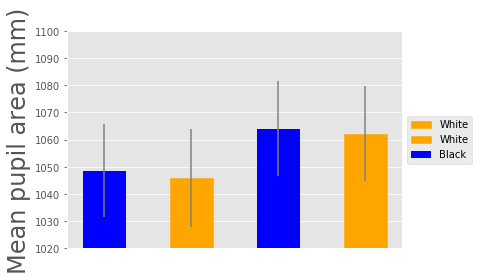

In [9]:
import matplotlib.patches as mpatches
from collections import OrderedDict


# Initialising Datamatrix.
dm_analysis = DataMatrix(length=960)
dm_analysis.set = "NA"
dm_analysis.target_shape = "NA"
dm_analysis.target_color = "NA"
dm_analysis.ps = "NA"
dm_analysis.num_trial = "NA"
dm_analysis.subj_nr = "NA"

# Interval sets of the first RSVP stream.
interval_sets = [[0,413],
                  [413,826],
                  [826,1238],
                  [1238,1651]] 

def fill_dm_analysis(dm_analysis,dm,num_trial,subj, count,interval_set,ps):
     
    """
        Store identity (color/shape) target
    """          
    
    if  dm.start_color[0] == "black":
        alternative_color = "white"
    elif dm.start_color[0] == "white":
        alternative_color = "black"
    
    
    if interval_set % 2 == 0:
        if dm.start_shape == dm.presented_shape:
            dm_analysis.target_color[count] = dm.start_color[0]
        else:
            dm_analysis.target_color[count] = alternative_color
            
    elif interval_set % 2 != 0:
        if dm.start_shape[0] == dm.presented_shape:
            dm_analysis.target_color[count] = alternative_color
        else:
            dm_analysis.target_color[count] = dm.start_color[0]

                
    # Setting dm_analysis.
    dm_analysis.target_shape[count] = dm.presented_shape[0]
    dm_analysis.set[count] = interval_set + 1
    dm_analysis.ps[count] = ps
    dm_analysis.num_trial[count] = num_trial
    dm_analysis.subj_nr[count] = subj

    return dm_analysis


## Looping to fil dm_analysis.
count = 0
for (subj,dm_subj) in (ops.split(dm.subject_nr)):
    for (num_trial,dm_num_trial) in (ops.split(dm_subj.num_trial)):
        for interval_set,interval in enumerate(interval_sets):
            ps = srs.reduce_(srs.window(dm_num_trial.pupil, interval[0], interval[1])).mean
            dm_analysis = fill_dm_analysis(dm_analysis,dm_num_trial,num_trial,subj, count,interval_set,ps)
            count += 1
            
# Filling arrays
list_ps = []
list_se = []

print(dm_analysis)
## Plotting
for (shape,dm_shape) in (ops.split(dm_analysis.target_shape)):
    for (color,dm_color) in (ops.split(dm_shape.target_color)):
        print("Shape", shape, "Color", color)
        list_ps = np.append(list_ps,dm_color.ps.mean)
        se = dm_color.ps.std/np.sqrt(len(dm_color.ps))
        list_se = np.append(list_se,se)

# Removing nans.
list_ps = list_ps[~np.isnan(list_ps)]
list_se = list_se[~np.isnan(list_se)]

barlist = plt.bar(np.arange(len(list_ps)),list_ps, width = 0.5,color = "blue",label = "Black", yerr = list_se,ecolor = "grey")  

for i in range(len(barlist)):
    if i % 2 != 0:
        barlist[i].set_color('orange')
        barlist[i].set_label('White')
        
axes = plt.gca()
box = axes.get_position()

locs, labels = plt.xticks()
plt.ylim(1020, 1100)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.ylabel("Mean pupil area (mm)",fontsize=24)

# Placing the legend outside the graph.
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("Mean ps per target combination",bbox_inches="tight")


plt.show()



        



# Calculate ITR.

In [10]:
import math

dm_analysis_itr = DataMatrix(length=10)
dm_analysis_itr.subj_nr = "NA"
dm_analysis_itr.acc = "NA"
dm_analysis_itr.rt = "NA"
dm_analysis_itr.itr = "NA"

# Number of options
N = 2

for (subj,dm_subj) in (ops.split(dm.subject_nr)):
    dm_analysis_itr[subj-1].subj_nr = subj
    dm_analysis_itr[subj-1].acc = (dm_subj.percentage_correct[len(dm_subj)-1]/100)
    
    # Stimulus + blank = 516ms 
    # One RSVP is 32 stimuli -> 32 * 516ms = 16512ms -> 16.5s
    dm_analysis_itr[subj-1].rt = dm_subj.rsvp_count.mean * 16.5
        
    
    dm_analysis_itr[subj-1].itr = (math.log2(N) + (dm_analysis_itr.acc[subj-1] * math.log2(dm_analysis_itr.acc[subj-1])) + (1-dm_analysis_itr.acc[subj-1])* math.log2(((1-dm_analysis_itr.acc[subj-1]))/(N-1)))/(dm_analysis_itr[subj-1].rt/60)
print(dm_analysis_itr )
print("Mean itr",dm_analysis_itr.itr.mean)

+---+---------------------+----------------------+--------------------+---------+
| # |         acc         |         itr          |         rt         | subj_nr |
+---+---------------------+----------------------+--------------------+---------+
| 0 |  0.6666666666669999 | 0.10486096164172458  |       46.75        |    1    |
| 1 |    0.583333333333   |  0.0283372340392053  |       42.625       |    2    |
| 2 | 0.45833333333299997 | 0.007957958581067702 |      37.8125       |    3    |
| 3 |  0.7083333333330001 | 0.17888904694609012  |      43.3125       |    4    |
| 4 |         0.5         |          0           |        49.5        |    5    |
| 5 |        0.625        | 0.07364201547480395  |       37.125       |    6    |
| 6 |    0.583333333333   | 0.02546244218015549  |      47.4375       |    7    |
| 7 |  0.6666666666669999 | 0.12202570238664973  | 40.173913043478265 |    8    |
| 8 |         0.5         |          0           |      47.4375       |    9    |
| 9 |    0.58333